In [1]:
import os 
import cv2
import time 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as ans 
from tqdm import tqdm 
import shutil 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import Model
from tensorflow.keras import layers 
from tensorflow.keras.layers import *
import tensorflow_datasets as tfds
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import *
from datetime import datetime
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Input, UpSampling2D, Conv2DTranspose, Conv2D, add, Add,\
                    Lambda, Concatenate, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, \
                    Add, LayerNormalization, Activation, LeakyReLU
try:
    import tensorflow_addons as tfa 
except:
    !pip install tensorflow_addons
    import tensorflow_addons as tfa
    from tensorflow_addons.layers import InstanceNormalization

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
BATCH_SIZE = 1
HR_CROP_SIZE = 96
NUM_RES_BLOCK = 16
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

HR_IMG_DIMS = (96, 96, 3)

In [3]:
div2k = tfds.image.Div2k(config='bicubic_x4')
div2k.download_and_prepare()

# train data
train_ds = div2k.as_dataset(split='train',as_supervised=True)  # 800 hr and 800 lr images
# validation data
val_ds = div2k.as_dataset(split='validation',as_supervised=True)  # 100 hr and 199 lr images

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteNK99KY/div2k-train.tfrecord*...:   0%|   …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteNK99KY/div2k-validation.tfrecord*...:   0…

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


In [4]:
def resize_images(lr_img, hr_img):
    lr_img = tf.image.resize(lr_img, (LR_IMG_DIMS[0], LR_IMG_DIMS[1]))
    hr_img = tf.image.resize(hr_img, (HR_IMG_DIMS[0], HR_IMG_DIMS[1]))
    
    lr_img = tf.cast(lr_img, tf.float32)
    hr_img = tf.cast(hr_img, tf.float32)
    
    return lr_img, 


def random_crop(lr_img, hr_img, scale=4, hr_crop_size=96):
    ''' This function crops lr(64*64) and hr(256*256) images'''
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped


def random_flip(lr_img, hr_img):
    ''' This function will flip imag left_right randomly'''
    random = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(random < 0.5,lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))

        
def random_rotate(lr_img, hr_img):
    ''' This function will rotate image randomly to 90 degree'''
    rand = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rand), tf.image.rot90(hr_img, rand)

In [5]:
def data_augmentation(lr_img, hr_img):
    lr_img = tf.cast(lr_img, tf.float32)
    hr_img = tf.cast(hr_img, tf.float32)
    lr_img, hr_img = random_crop(lr_img, hr_img)
    lr_img, hr_img = random_rotate(lr_img, hr_img)
    lr_img, hr_img = random_flip(lr_img, hr_img)
    
    return lr_img, hr_img

In [6]:
train_ds = (train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
                    .batch(BATCH_SIZE, drop_remainder=True)
                    .prefetch(tf.data.AUTOTUNE))

val_ds = (val_ds.repeat(1)
                    .batch(1, drop_remainder=True)
                #    .map(resize_images, num_parallel_calls=tf.data.AUTOTUNE)
                    .prefetch(tf.data.AUTOTUNE))

In [19]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(1, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, None, None, 3), dtype=tf.float32, name=None))>

In [20]:
sample_data = next(iter(train_ds))

Text(0.5, 1.0, 'high Resolution Image')

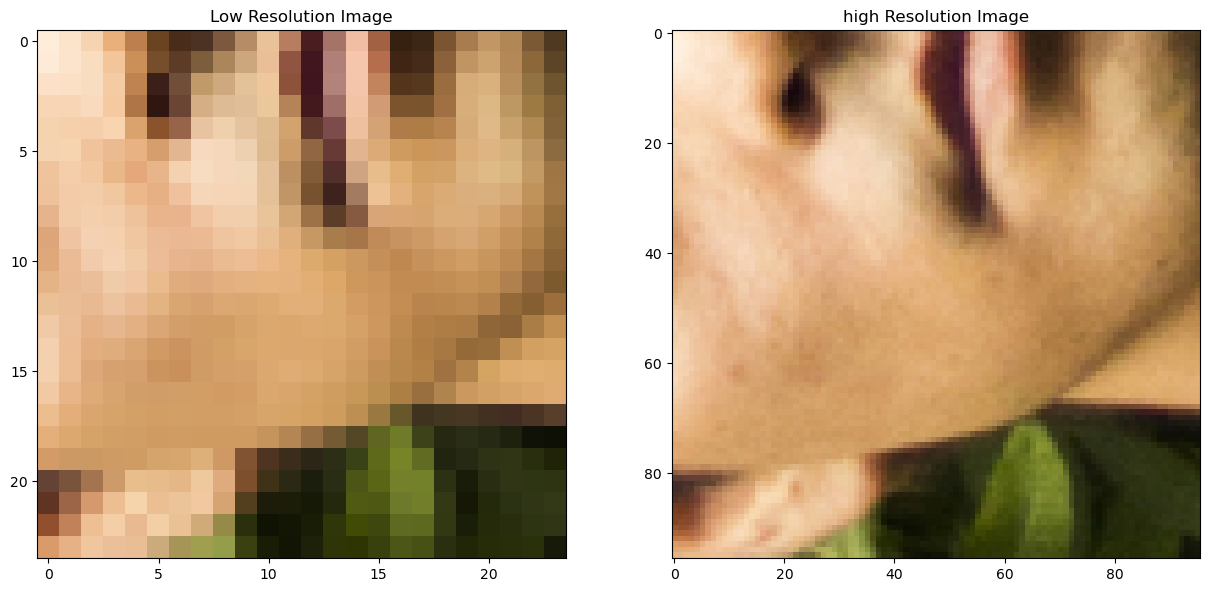

In [21]:
lr_sample_image = sample_data[0][0]
hr_sample_image = sample_data[1][0]

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(lr_sample_image/255.0)
plt.title("Low Resolution Image")

plt.subplot(1, 2, 2)
plt.imshow(hr_sample_image/255.0)
plt.title("high Resolution Image")

In [7]:
def residual_block(inputs):
    x = Conv2D(64, (3,3), padding = "same")(inputs)
    x = BatchNormalization(momentum = 0.5)(x)
    x = PReLU(shared_axes = [1,2])(x)
    x = Conv2D(64, (3,3), padding = "same")(x)
    x = BatchNormalization(momentum = 0.5)(x)
    result = add([inputs, x])
    
    return result

def upsample(x_in, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = Lambda(pixel_shuffle(scale=2))(x)
    return PReLU(shared_axes=[1, 2])(x)

def get_generator():
    inputs = Input(shape=(None, None, 3))
    x = Conv2D(64, (9,9), padding="same")(inputs)
    x = PReLU(shared_axes=[1,2])(x)
    
    skip_x = x 
    for _ in range(NUM_RES_BLOCK):
        x = residual_block(x)
        
    x = Conv2D(64, (3,3), padding="same")(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = add([skip_x, x])
    x = upsampling_block(x)
    x = upsampling_block(x)
    
    output = Conv2D(3, (9,9), padding="same")(x)
    return Model(inputs, output)

In [8]:
def normalize_01(x):
    """Normalizes RGB images to [0, 1]."""
    return x / 255.0

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

def normalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return (x - rgb_mean) / 127.5


def denormalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return x * 127.5 + rgb_mean


def normalize_01(x):
    """Normalizes RGB images to [0, 1]."""
    return x / 255.0


def normalize_m11(x):
    """Normalizes RGB images to [-1, 1]."""
    return x / 127.5 - 1


def denormalize_m11(x):
    """Inverse of normalize_m11."""
    return (x + 1) * 127.5

def upsample(x_in, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = Lambda(pixel_shuffle(scale=2))(x)
    return PReLU(shared_axes=[1, 2])(x)


def res_block(x_in, num_filters, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = BatchNormalization(momentum=momentum)(x)
    x = PReLU(shared_axes=[1, 2])(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=momentum)(x)
    x = Add()([x_in, x])
    return x


def get_generator(num_filters=64, num_res_blocks=16):
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize_01)(x_in)

    x = Conv2D(num_filters, kernel_size=9, padding='same')(x)
    x = x_1 = PReLU(shared_axes=[1, 2])(x)

    for _ in range(NUM_RES_BLOCK):
        x = res_block(x, num_filters)

    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_1, x])

    x = upsample(x, num_filters * 4)
    x = upsample(x, num_filters * 4)

    x = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    x = Lambda(denormalize_m11)(x)

    return Model(x_in, x)


In [9]:
generator = get_generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, to_file='srgan_generator.png', dpi=60)
#generator.summary()

In [10]:
def discriminator_block(filters, strides=1, bn=True):   
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, (3,3), strides = strides, padding="same"))
    if bn:
        result.add(BatchNormalization(momentum=0.8))
    result.add(LeakyReLU(alpha=0.2))
    
    return result


In [11]:
# start with filter size of 64, every 2 block multiple filter * 2
def get_discriminator():
    
    inputs = Input(shape=HR_IMG_DIMS)
    x = discriminator_block(64, 1, False)(inputs)    # filter = 64
    x = discriminator_block(64, strides=2)(x)        # filter = 64 
    x = discriminator_block(128)(x)                  # filter = 128 
    x = discriminator_block(128, strides=2)(x)       # filter = 128 
    x = discriminator_block(256)(x)                  # filter = 256 
    x = discriminator_block(256, strides=2)(x)       # filter = 256 
    x = discriminator_block(512)(x)                  # filter = 512
    x = discriminator_block(512, strides=2)(x)       # filter = 512
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    output = Dense(1)(x)
    return Model(inputs, output)

In [ ]:
discriminator = get_discriminator()

tf.keras.utils.plot_model(discriminator, show_shapes=True, to_file='srgan_generator.png', dpi=60)
discriminator.summary()

In [12]:
def get_perceptual_model(n_layers=10):
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=HR_IMG_DIMS)
    return Model(inputs=vgg.inputs, outputs=vgg.layers[n_layers].output)

In [13]:
class SRGANModel(keras.models.Model): 
    def __init__(self, generator, discriminator, perceptual_model):
        super(SRGANModel, self).__init__()
        self.generator_loss_tracker = tf.keras.metrics.Mean()
        self.discriminator_loss_tracker =  tf.keras.metrics.Mean()
        
        self.generator = generator
        self.discriminator = discriminator
        self.perceptual_model = perceptual_model
        
        self.summary_writer = tf.summary.create_file_writer(
        "logs/" + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    @property
    def metrics(self):
        pass 
    
    def compile(self, generator_optimizer, discriminator_optimizer):
        super().compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
    
    def train_step(self, inputs):
        lr_img, hr_img = inputs
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            hr_gen_img = self.generator(lr_img, training=True)
            
            # with vgg extrack feature maps of he images
            fmap_hr_gen = self.perceptual_model(hr_gen_img, training=False)
            fmap_hr_real = self.perceptual_model(hr_img, training=False)
            
            # discriminator outputs
            disc_fake_output = self.discriminator(hr_gen_img, training=True)
            disc_real_output = self.discriminator(hr_img, training=True)
            
            # ca;culating loss
            disc_loss = self.compute_dis_loss(disc_real_output, disc_fake_output)
            adversial_loss = self.compute_gen_loss(disc_fake_output)
            content_loss = self.compute_content_loss(hr_gen_img, hr_img)
            total_gen_loss = (10e-3 * adversial_loss) + content_loss

            # Params
        disc_params = self.discriminator.trainable_weights
        gen_params = self.generator.trainable_weights
        
        # grads
        disc_grads = disc_tape.gradient(disc_loss, disc_params)
        gen_grads = gen_tape.gradient(total_gen_loss, gen_params)
        
        # Back Propagate
        self.generator_optimizer.apply_gradients(zip(gen_grads, gen_params))
        self.discriminator_optimizer.apply_gradients(zip(disc_grads, disc_params))
        
        # loss tracker
        self.generator_loss_tracker.update_state(total_gen_loss)
        self.discriminator_loss_tracker.update_state(disc_loss)

        #with self.summary_writer.as_default():
        #tf.summary.scalar('gen_total_loss', total_gen_loss, step=step//1000)
        #tf.summary.scalar('gen_gan_loss', gan_loss, step=step//1000)
        #tf.summary.scalar('gen_l1_loss', l1_loss, step=step//1000)
        #tf.summary.scalar('disc_loss', total_disc_loss, step=step//1000)
        return {
                "gen_loss": self.generator_loss_tracker.result(), 
                "disc_loss": self.discriminator_loss_tracker.result(), 
               }
    
    def test_step(self, val_ds):
        psnr_val = self.get_psnr(val_ds)
        ssim_val = self.get_ssim(val_ds)
        
        return psnr_val, ssim_val
    
        
    def compute_dis_loss(self, real_img_output, fake_img_output):
        # fake image  output by the discrimnator
        loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        # real image loss (30 * 30 * 3)
        real_loss = loss_object(tf.ones_like(real_img_output), real_img_output)
        # real image loss (30 * 30 * 3)
        fake_loss = loss_object(tf.zeros_like(fake_img_output), fake_img_output)
        total_loss = real_loss + fake_loss
        
        return total_loss * 0.5
    
    def compute_gen_loss(self, fake_img_output):
        # fake image  output by the discrimnator
        loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        # Gan loss
        gan_loss = loss_object(tf.ones_like(fake_img_output), fake_img_output)

        return gan_loss
    
    def compute_identity_loss(self, real_image, same_image):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return loss
    
    def compute_content_loss(self, real_image, gen_image):
        loss1 = tf.reduce_mean(tf.abs(real_image - gen_image))
        
        return loss1
    
    def call(self, inputs):
        X, y = inputs 
        gen_output = self.generator(X)
        return gen_output
    
    def get_psnr(self, ds):
        psnr_values = []
        for lr, hr in ds:
            # convert dtype to float32
            lr = tf.cast(lr, tf.float32)
            # get sr image from model
            sr = self.generator(lr)
            # clip values to 0,255
            sr = tf.clip_by_value(sr, 0, 255)
            # round up values
            sr = tf.round(sr)
            # change dtype to unint8
            sr = tf.cast(sr, tf.uint8)
            # get psnr value
            psnr_value = tf.image.psnr(hr, sr, max_val=255)[0]
            # append psnr value
            psnr_values.append(psnr_value)
        return tf.reduce_mean(psnr_values)
    
    def get_ssim(self, ds):
        ssim_values = []
        for lr,hr in ds:
            # convert dtype to float32
            lr = tf.cast(lr, tf.float32)
            # get sr image from model
            sr = self.generator(lr)
            # clip values to 0,255
            sr = tf.clip_by_value(sr, 0, 255)
            # round up values
            sr = tf.round(sr)
            # change dtype to unint8
            sr = tf.cast(sr, tf.uint8)
            # get ssim value
            ssim_value = tf.image.ssim(hr, sr, max_val=255).numpy()[0]
            # append ssim value
            ssim_values.append(ssim_value)
        return tf.reduce_mean(ssim_values)
    
    def get_mos(self, ds):
        pass 

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [15]:
generator = get_generator()
discriminator = get_discriminator()
perceptual_model = get_perceptual_model()

80134624/80134624 [==============================] - 3s 0us/step


In [16]:
model = SRGANModel(generator, discriminator, perceptual_model)
model.compile(generator_optimizer, discriminator_optimizer)

In [17]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1),
                           generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer,
                           model=model,
                           psnr=tf.Variable(-1.0),
                           ssim = tf.Variable(-1.0)
                          )
manager = tf.train.CheckpointManager(ckpt, './srgan_chkpt', max_to_keep=3)

In [18]:
def train(model, train_ds, test_ds, epochs, manager):
    gen_loss_list = []
    psnr_list = []
    ssim_list = []
    disc_loss_list = []
    
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    
    for epoch in range(epochs):
        for step, train_data_batch in tqdm(enumerate(train_ds), total=len(train_ds)):
            result = model.train_step(train_data_batch)
            gen_loss = result.get("gen_loss")
            disc_loss = result.get("disc_loss")
            
            ckpt.step.assign_add(1)
            
        # test step
        psnr_val, ssim_val = model.test_step(test_ds)
        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)
        
        if psnr_val > ckpt.psnr: 
            save_path = manager.save()
            ckpt.psnr = psnr_val
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
        
        m_psnr_val = np.mean(psnr_list)
        m_ssim_val = np.mean(ssim_list)
        gen_loss_list.append(gen_loss)
        disc_loss_list.append(disc_loss)
        
        print(f"Epochs: {epoch}, gen_loss: {gen_loss}, disc_loss: {disc_loss} PSNR: {m_psnr_val}, SSIM: {m_ssim_val}")
    return model

In [23]:
model = train(model, train_ds, val_ds, 5, manager)

Restored from ./srgan_chkpt/ckpt-27


100%|██████████| 800/800 [07:04<00:00,  1.88it/s]


Epochs: 0, gen_loss: 10.147165298461914, disc_loss: 0.11237747967243195 PSNR: 26.979595184326172, SSIM: 0.775179922580719


100%|██████████| 800/800 [07:05<00:00,  1.88it/s]


Epochs: 1, gen_loss: 10.118000030517578, disc_loss: 0.1117057353258133 PSNR: 27.12664794921875, SSIM: 0.7760902643203735


100%|██████████| 800/800 [07:05<00:00,  1.88it/s]


Epochs: 2, gen_loss: 10.092853546142578, disc_loss: 0.11123939603567123 PSNR: 26.96665382385254, SSIM: 0.7765960693359375


100%|██████████| 800/800 [07:06<00:00,  1.88it/s]


Epochs: 3, gen_loss: 10.065627098083496, disc_loss: 0.1106313094496727 PSNR: 27.015195846557617, SSIM: 0.775969386100769


100%|██████████| 800/800 [07:07<00:00,  1.87it/s]


Epochs: 4, gen_loss: 10.041971206665039, disc_loss: 0.11026354134082794 PSNR: 27.065725326538086, SSIM: 0.7755348086357117


In [24]:
model.generator.save_weights("srgan_generator_16_4x_bc.h5")  
model.discriminator.save_weights("srgan_discriminator_16_4x_bc.h5") 

In [25]:
srgan = get_generator()

srgan.load_weights("srgan_generator_16_4x_bc.h5")  

psnr; 24.89512825012207, ssim: 0.7476367354393005


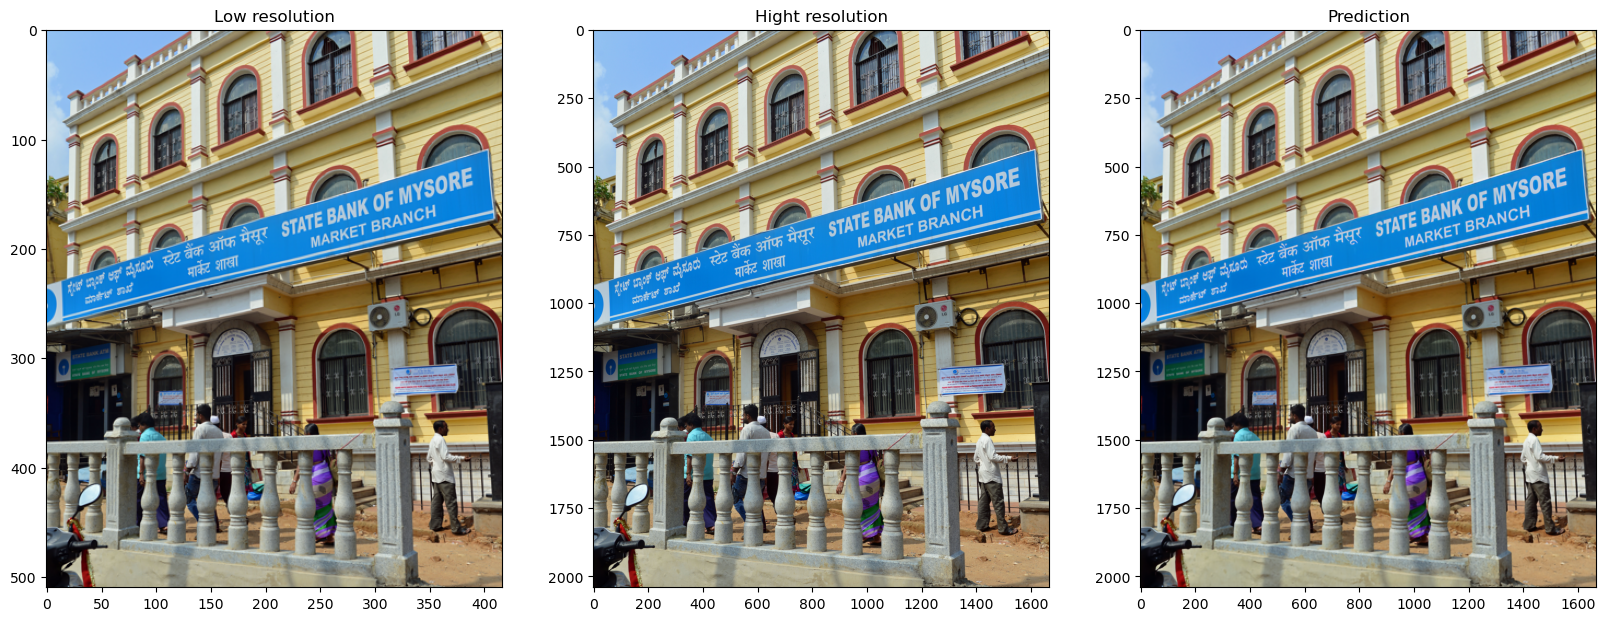

psnr; 27.41783332824707, ssim: 0.8032784461975098


<Figure size 640x480 with 0 Axes>

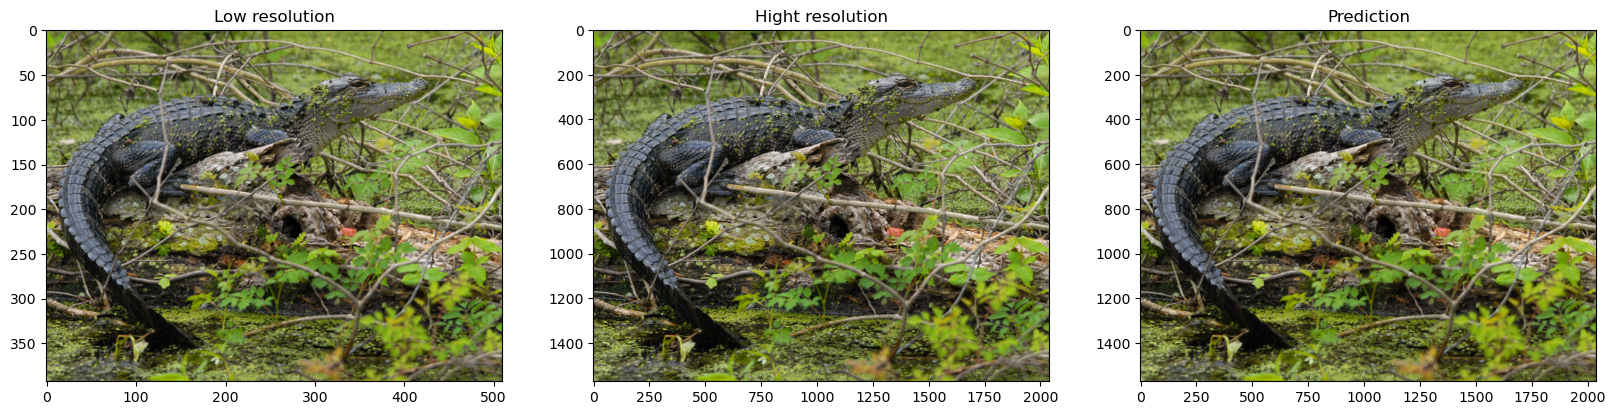

psnr; 26.05670166015625, ssim: 0.7383518815040588


<Figure size 640x480 with 0 Axes>

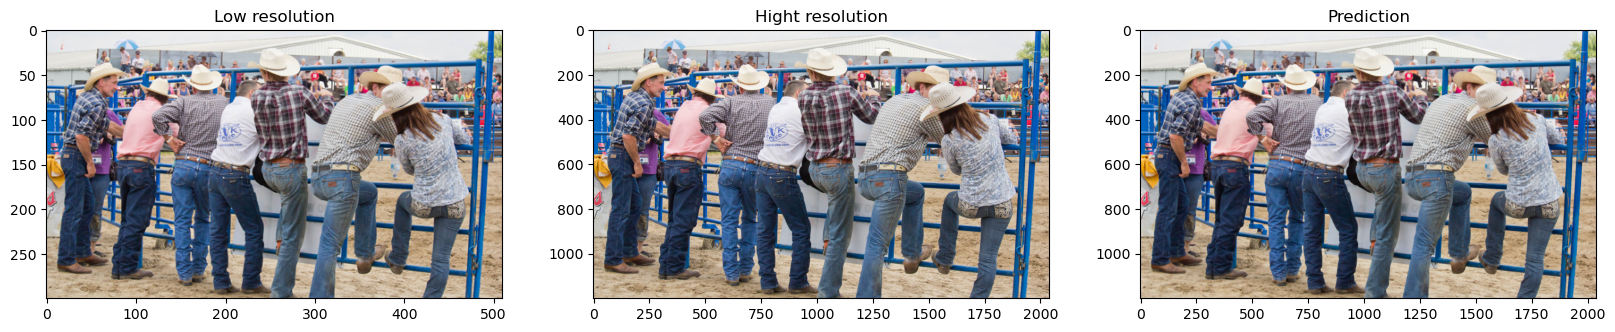

psnr; 33.09840393066406, ssim: 0.943828821182251


<Figure size 640x480 with 0 Axes>

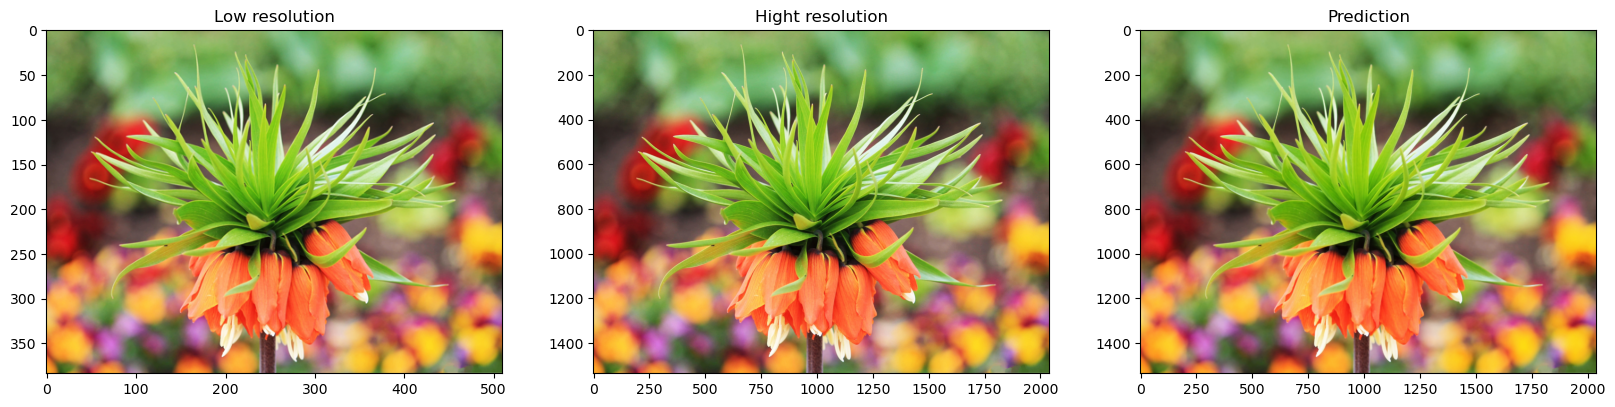

psnr; 28.917903900146484, ssim: 0.7513413429260254


<Figure size 640x480 with 0 Axes>

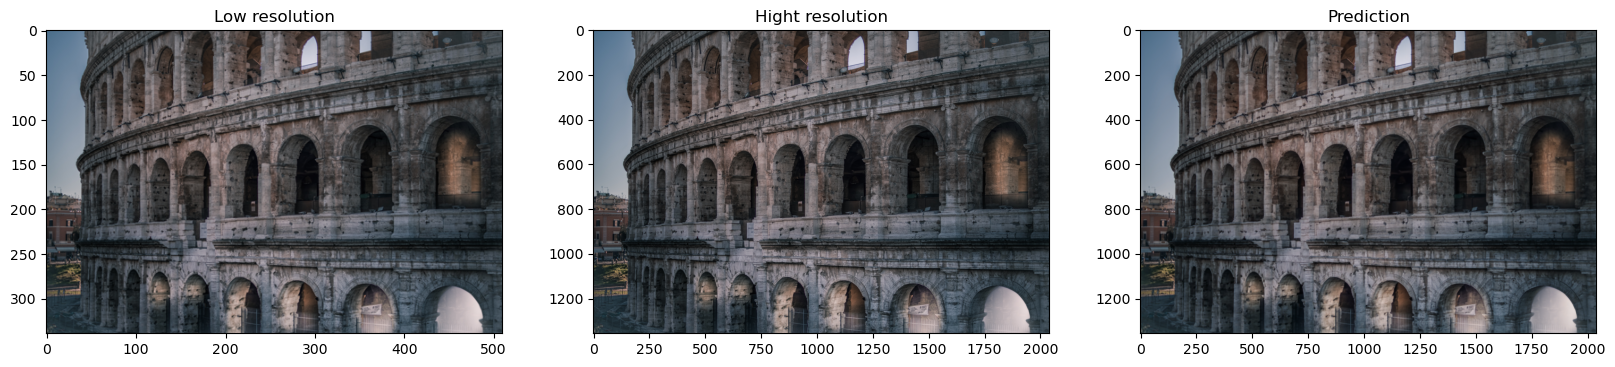

<Figure size 640x480 with 0 Axes>

In [27]:
def plot_results(lowres, preds, highres):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(20, 10))
    plt.subplot(131), plt.imshow(lowres/255.0), plt.title("Low resolution")
    plt.subplot(132), plt.imshow(highres/255.0), plt.title("Hight resolution")
    plt.subplot(133), plt.imshow(preds/255.0), plt.title("Prediction")
    plt.show()
    plt.savefig("wdsr_a_res.png")

for lr, hr in val_ds.take(5):
    lr = lr[0]
    hr = hr[0]

 #   lowres = tf.image.random_crop(lowres, (64, 64, 3))
    lr = tf.expand_dims(lr, 0)
    hr = tf.cast(hr, tf.float32)
    lr = tf.cast(lr, tf.float32)
    sr = srgan(lr)
    sr = sr[0]
    sr = tf.cast(sr, tf.float32)
    lr = lr[0]
    
    psnr = tf.image.psnr(sr, hr, max_val=255)
    ssim = tf.image.ssim(sr, hr, max_val=255)
    print(f"psnr; {psnr}, ssim: {ssim}")
    
    plot_results(lr, sr, hr)